
💹 OPTIMIZED RUPEE-COST-AVERAGING STRATEGY (LOGARITHMIC STEPS)
 Step  Price (₹)  Investment (₹)  Quantity  Actual Invested (₹)  Cumulative Qty  Average Cost (₹)
    1     100.00         1024.26        10              1000.00              10           100.000
    2      92.59         1504.60        16              1481.40              26            95.438
    3      85.72         2210.21        25              2143.11              51            90.677
    4      79.37         3246.72        40              3174.80              91            85.707
    5      73.49         4769.31        64              4703.15             155            80.661
    6      68.04         7005.95       102              6940.03             257            75.652
    7      63.00        10291.49       163             10268.36             420            70.740
    8      58.33        15117.83       259             15106.55             679            66.005
    9      54.00        22207.55       411             

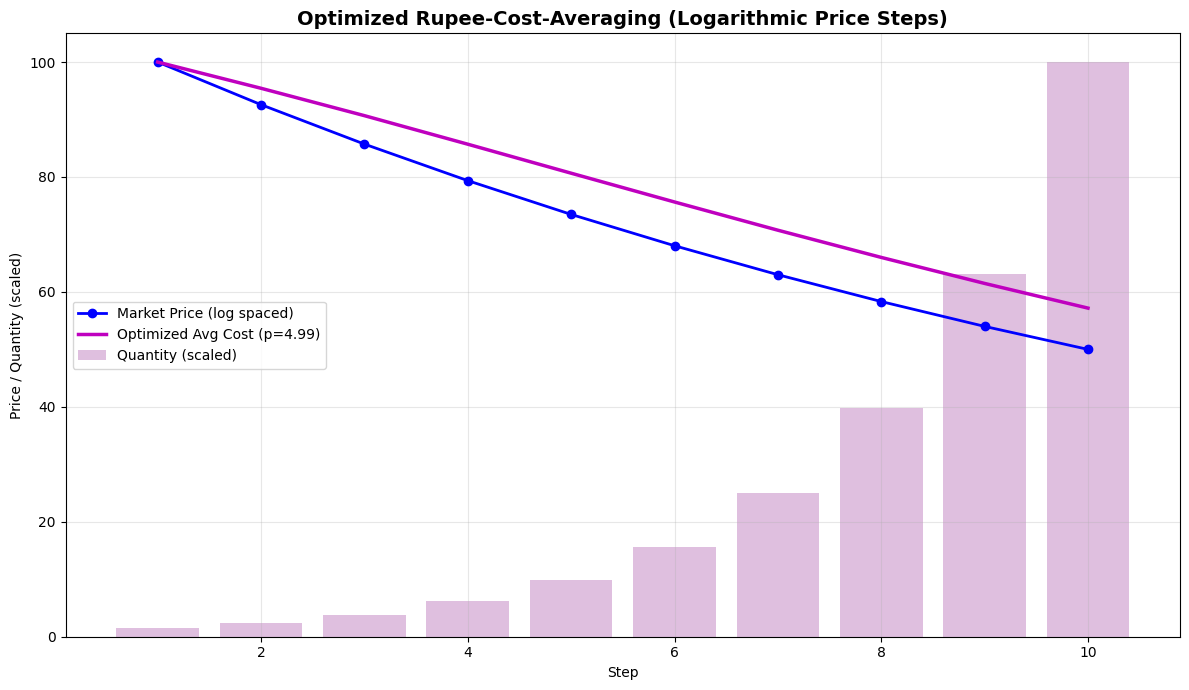


INSIGHTS:
--------------------------------------------------------------------------------
✓ Optimal sensitivity factor p = 4.99
→ Strategy invests *more aggressively* during price dips (steeper allocation).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# -----------------------------------------------------
# PARAMETERS
# -----------------------------------------------------
total_investment = 100000  # INR
num_steps = 10
initial_price = 100
final_price = 50

# Use logarithmic (geometric) spacing for prices
# This ensures equal *percentage* changes between steps
prices = np.geomspace(initial_price, final_price, num_steps)
steps = np.arange(1, num_steps + 1)

target_sell_price = 120  # ← adjustable target sell price


# -----------------------------------------------------
# FUNCTION TO COMPUTE AVERAGE COST FOR A GIVEN EXPONENT p
# -----------------------------------------------------
def avg_cost_for_p(p: float) -> float:
    """Compute average acquisition cost for a given exponent p."""
    weights = (1 / prices) ** p
    weights /= np.sum(weights)
    invest = total_investment * weights
    qty = np.floor(invest / prices)
    actual_invest = qty * prices
    total_qty = np.sum(qty)
    total_cost = np.sum(actual_invest)
    return total_cost / total_qty if total_qty > 0 else np.inf


# -----------------------------------------------------
# OPTIMIZE p TO MINIMIZE AVERAGE COST
# -----------------------------------------------------
res = minimize_scalar(avg_cost_for_p, bounds=(0, 5), method="bounded")
opt_p = res.x
min_avg_cost = res.fun

# -----------------------------------------------------
# APPLY OPTIMAL WEIGHTING FUNCTION
# -----------------------------------------------------
weights = (1 / prices) ** opt_p
weights /= np.sum(weights)
investments = total_investment * weights

quantities = np.floor(investments / prices).astype(int)
actual_investments = quantities * prices
cumulative_qty = np.cumsum(quantities)
cumulative_investment = np.cumsum(actual_investments)
avg_cost = cumulative_investment / cumulative_qty

# -----------------------------------------------------
# BUILD RESULTS TABLE
# -----------------------------------------------------
df = pd.DataFrame(
    {
        "Step": steps,
        "Price (₹)": np.round(prices, 2),
        "Investment (₹)": np.round(investments, 2),
        "Quantity": quantities,
        "Actual Invested (₹)": np.round(actual_investments, 2),
        "Cumulative Qty": cumulative_qty,
        "Average Cost (₹)": np.round(avg_cost, 3),
    }
)

# -----------------------------------------------------
# FINAL SUMMARY STATISTICS
# -----------------------------------------------------
total_qty = cumulative_qty[-1]
total_spent = cumulative_investment[-1]
final_value = total_qty * final_price
profit_loss = final_value - total_spent
profit_loss_pct = (profit_loss / total_spent) * 100

print("\n💹 OPTIMIZED RUPEE-COST-AVERAGING STRATEGY (LOGARITHMIC STEPS)")
print("=" * 90)
print(df.to_string(index=False))
print("=" * 90)
print(f"Optimal weighting exponent (p): {opt_p:.3f}")
print(f"Minimum achievable average cost: ₹{min_avg_cost:.3f}")
print(f"Total Quantity Acquired: {total_qty}")
print(f"Total Invested: ₹{total_spent:,.2f}")
print(f"Final Price: ₹{final_price:.2f}")
print(f"Final Portfolio Value: ₹{final_value:,.2f}")
print(f"Profit/Loss: ₹{profit_loss:,.2f} ({profit_loss_pct:+.2f}%)")
print("=" * 90)

# -----------------------------------------------------
# TARGET SELL PRICE & PROFIT SIMULATION
# -----------------------------------------------------
target_portfolio_value = total_qty * target_sell_price
target_profit_loss = target_portfolio_value - total_spent
target_profit_loss_pct = (target_profit_loss / total_spent) * 100

print("\n🎯 TARGET SELL SIMULATION")
print("=" * 90)
print(f"Target Sell Price: ₹{target_sell_price:.2f}")
print(f"Total Quantity: {total_qty}")
print(f"Total Invested: ₹{total_spent:,.2f}")
print(f"Portfolio Value at Target: ₹{target_portfolio_value:,.2f}")
print(
    f"Expected Profit/Loss: ₹{target_profit_loss:,.2f} ({target_profit_loss_pct:+.2f}%)"
)
print("=" * 90)

# -----------------------------------------------------
# VISUALIZATION
# -----------------------------------------------------
plt.figure(figsize=(12, 7))
plt.plot(steps, prices, "bo-", linewidth=2, label="Market Price (log spaced)")
plt.plot(
    steps, avg_cost, "m-", linewidth=2.5, label=f"Optimized Avg Cost (p={opt_p:.2f})"
)

plt.bar(
    steps,
    quantities * (max(prices) / max(quantities)),
    color="purple",
    alpha=0.25,
    label="Quantity (scaled)",
)

plt.title(
    "Optimized Rupee-Cost-Averaging (Logarithmic Price Steps)",
    fontsize=14,
    weight="bold",
)
plt.xlabel("Step")
plt.ylabel("Price / Quantity (scaled)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# INSIGHTS
# -----------------------------------------------------
print("\nINSIGHTS:")
print("-" * 80)
print(f"✓ Optimal sensitivity factor p = {opt_p:.2f}")
if opt_p > 1:
    print(
        "→ Strategy invests *more aggressively* during price dips (steeper allocation)."
    )
elif opt_p < 1:
    print("→ Strategy invests *more evenly* across steps (less responsive to dips).")
else:
    print("→ Strategy roughly matches standard inverse-price DCA weighting.")